In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('data_prepared.csv')

In [19]:
categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical.remove("Attrition")

In [20]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [28]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.Attrition.values
y_val = df_val.Attrition.values
y_test = df_test.Attrition.values

del df_train['Attrition']
del df_val['Attrition']
del df_test['Attrition']

In [29]:
dv = DictVectorizer(sparse=False)

In [30]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [31]:
# Models for comparison
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1)
}

# Parameter grids for GridSearch
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': [None, 'balanced']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    }
}

# Train and tune models with cross-validation
best_models = {}
cv_results = {}
val_results = {}

for name, model in models.items():
    print(f"Training {name} with cross-validation...")
    
    # GridSearchCV with cross-validation
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    # Save best model and results
    best_models[name] = grid_search.best_estimator_
    cv_results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_
    }
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV score for {name}: {grid_search.best_score_:.4f}")
    print("-" * 60)

Training Logistic Regression with cross-validation...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Logistic Regression: {'C': 0.1, 'class_weight': None, 'solver': 'lbfgs'}
Best CV score for Logistic Regression: 0.7955
------------------------------------------------------------
Training Random Forest with cross-validation...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for Random Forest: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score for Random Forest: 0.8029
------------------------------------------------------------
Training Gradient Boosting with cross-validation...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best CV score for Gradient Boosting: 0.8010
------------------------------------------------------------


In [32]:
cv_summary = []
for name in models.keys():
    cv_summary.append({
        'Model': name,
        'Best CV ROC-AUC': cv_results[name]['best_score'],
        'Best Parameters': str(cv_results[name]['best_params'])
    })

cv_summary_df = pd.DataFrame(cv_summary)
print("CROSS-VALIDATION SUMMARY:")
print("=" * 80)
print(cv_summary_df.to_string(index=False))

CROSS-VALIDATION SUMMARY:
              Model  Best CV ROC-AUC                                                                      Best Parameters
Logistic Regression         0.795491                                  {'C': 0.1, 'class_weight': None, 'solver': 'lbfgs'}
      Random Forest         0.802858 {'class_weight': None, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
  Gradient Boosting         0.801026        {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


In [37]:
def evaluate_model(model, X, y, name):
    y_pred = model.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, y_pred)
    precision = precision_score(y, (y_pred > 0.5).astype(int), zero_division=0)
    recall = recall_score(y, (y_pred > 0.5).astype(int))
    f1 = f1_score(y, (y_pred > 0.5).astype(int))
    
    return {
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluate on validation set
print("\nVALIDATION SET RESULTS:")
print("=" * 80)
val_summary = []

for name, model in best_models.items():
    results = evaluate_model(model, X_val, y_val, name)
    val_summary.append({
        'Model': name,
        'ROC-AUC': results['auc'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1']
    })
    val_results[name] = results

val_summary_df = pd.DataFrame(val_summary)
print(val_summary_df.round(4).to_string(index=False))


VALIDATION SET RESULTS:
              Model  ROC-AUC  Precision  Recall  F1-Score
Logistic Regression   0.8049     0.8462  0.2500    0.3860
      Random Forest   0.7958     0.6429  0.2045    0.3103
  Gradient Boosting   0.7626     0.6667  0.3182    0.4308


In [38]:
# Select best model based on ROC-AUC
best_model_name = max(val_results, key=lambda x: val_results[x]['auc'])
best_model = best_models[best_model_name]

print(f"\nBEST MODEL SELECTED: {best_model_name}")
print(f"Validation ROC-AUC: {val_results[best_model_name]['auc']:.4f}")
print(f"Validation F1-Score: {val_results[best_model_name]['f1']:.4f}")


BEST MODEL SELECTED: Logistic Regression
Validation ROC-AUC: 0.8049
Validation F1-Score: 0.3860


In [40]:
test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [41]:
# Evaluate best model on test set
print("\nTEST SET RESULTS:")
print("=" * 50)
test_results = evaluate_model(best_model, X_test, y_test, best_model_name)

# Compare all models on test set
print("\nCOMPARISON OF ALL MODELS ON TEST SET:")
print("=" * 60)
test_comparison = []

for name, model in best_models.items():
    results = evaluate_model(model, X_test, y_test, name)
    test_comparison.append({
        'Model': name,
        'ROC-AUC': results['auc'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1']
    })

test_comparison_df = pd.DataFrame(test_comparison)
print(test_comparison_df.round(4).to_string(index=False))


TEST SET RESULTS:

COMPARISON OF ALL MODELS ON TEST SET:
              Model  ROC-AUC  Precision  Recall  F1-Score
Logistic Regression   0.8301     0.9375  0.2586    0.4054
      Random Forest   0.7938     0.7368  0.2414    0.3636
  Gradient Boosting   0.7803     0.5357  0.2586    0.3488


In [42]:
# Create comprehensive summary table
final_summary = []
for name in models.keys():
    test_metrics = evaluate_model(best_models[name], X_test, y_test, name)
    final_summary.append({
        'Model': name,
        'CV ROC-AUC': cv_results[name]['best_score'],
        'Val ROC-AUC': val_results[name]['auc'],
        'Test ROC-AUC': test_metrics['auc'],
        'Test Precision': test_metrics['precision'],
        'Test Recall': test_metrics['recall'],
        'Test F1': test_metrics['f1']
    })

final_summary_df = pd.DataFrame(final_summary)
print("\nCOMPREHENSIVE PERFORMANCE SUMMARY:")
print("=" * 100)
print(final_summary_df.round(4).to_string(index=False))

# Highlight best model
best_test_auc = final_summary_df['Test ROC-AUC'].max()
best_model_final = final_summary_df[final_summary_df['Test ROC-AUC'] == best_test_auc]['Model'].iloc[0]
print(f"\n🎯 FINAL BEST MODEL: {best_model_final} (Test ROC-AUC: {best_test_auc:.4f})")


COMPREHENSIVE PERFORMANCE SUMMARY:
              Model  CV ROC-AUC  Val ROC-AUC  Test ROC-AUC  Test Precision  Test Recall  Test F1
Logistic Regression      0.7955       0.8049        0.8301          0.9375       0.2586   0.4054
      Random Forest      0.8029       0.7958        0.7938          0.7368       0.2414   0.3636
  Gradient Boosting      0.8010       0.7626        0.7803          0.5357       0.2586   0.3488

🎯 FINAL BEST MODEL: Logistic Regression (Test ROC-AUC: 0.8301)



FEATURE IMPORTANCE ANALYSIS:

Top 10 Features - Random Forest:
                feature  importance
          MonthlyIncome      0.1176
                    Age      0.0871
         YearsAtCompany      0.0691
      TotalWorkingYears      0.0684
   YearsWithCurrManager      0.0514
         JobInvolvement      0.0495
           OverTime=Yes      0.0486
EnvironmentSatisfaction      0.0478
     YearsInCurrentRole      0.0471
            OverTime=No      0.0434


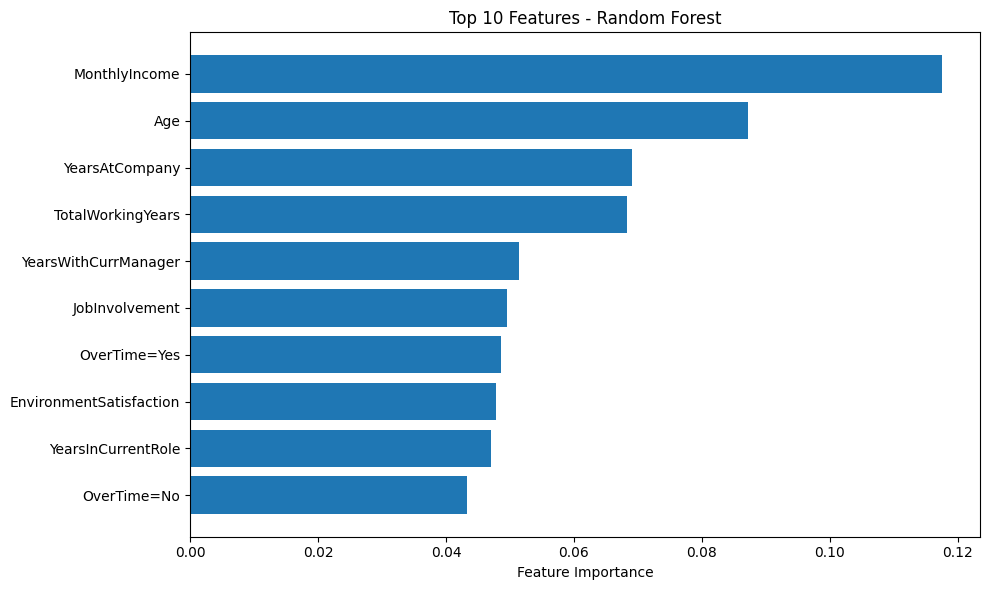


Top 10 Features - Gradient Boosting:
                feature  importance
          MonthlyIncome      0.1924
                    Age      0.1127
         YearsAtCompany      0.0776
      TotalWorkingYears      0.0612
         JobInvolvement      0.0563
            OverTime=No      0.0412
EnvironmentSatisfaction      0.0406
   YearsWithCurrManager      0.0401
       StockOptionLevel      0.0398
           OverTime=Yes      0.0353


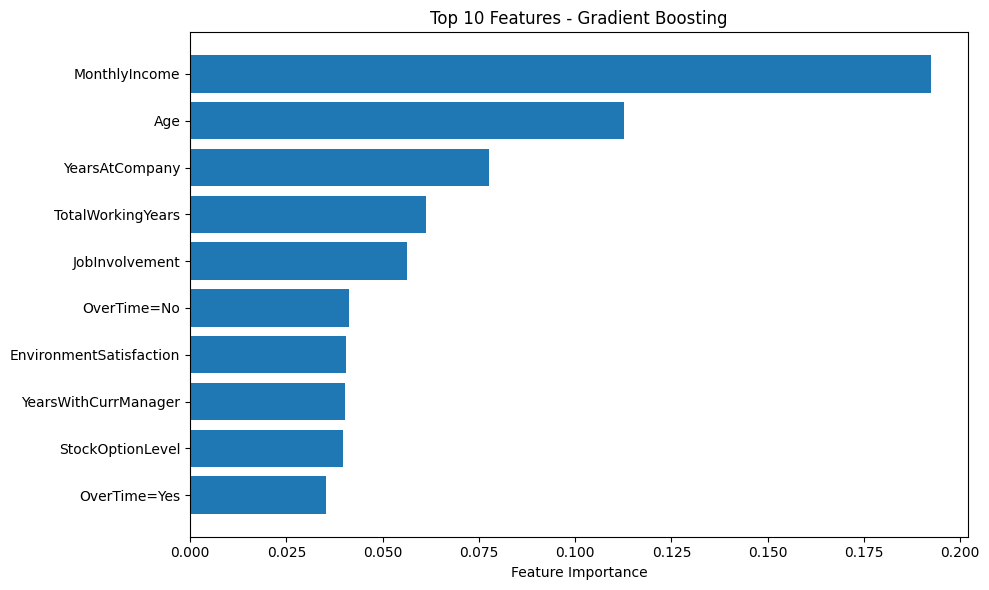

In [45]:
# Feature importance for tree-based models
print("\nFEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)

for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame({
            'feature': dv.feature_names_,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Features - {name}:")
        print(feature_importances.head(10).round(4).to_string(index=False))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importances.head(10)
        plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 10 Features - {name}')
        plt.tight_layout()
        plt.show()


Learning Curve for Best Model (Logistic Regression):


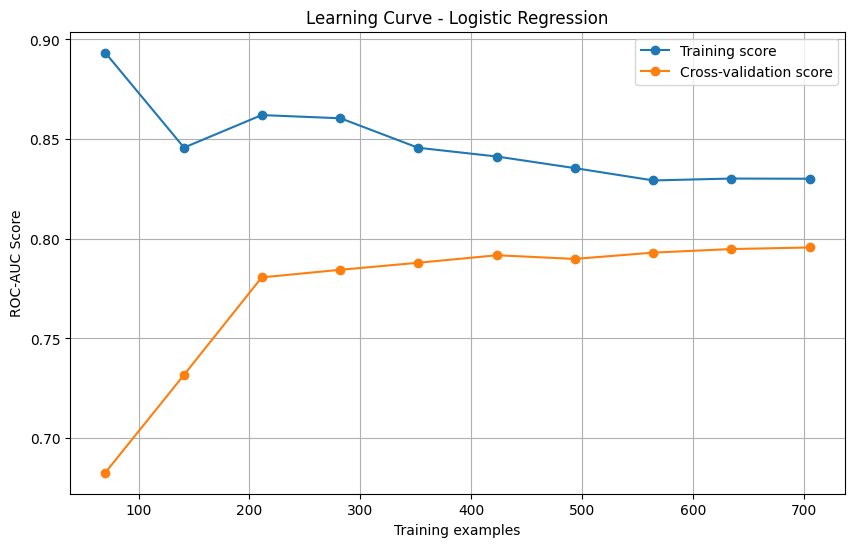

In [46]:
from sklearn.model_selection import learning_curve

# Learning curve for best model
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='roc_auc', 
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('ROC-AUC Score')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

print(f"\nLearning Curve for Best Model ({best_model_name}):")
plot_learning_curve(best_model, X_train, y_train, best_model_name)

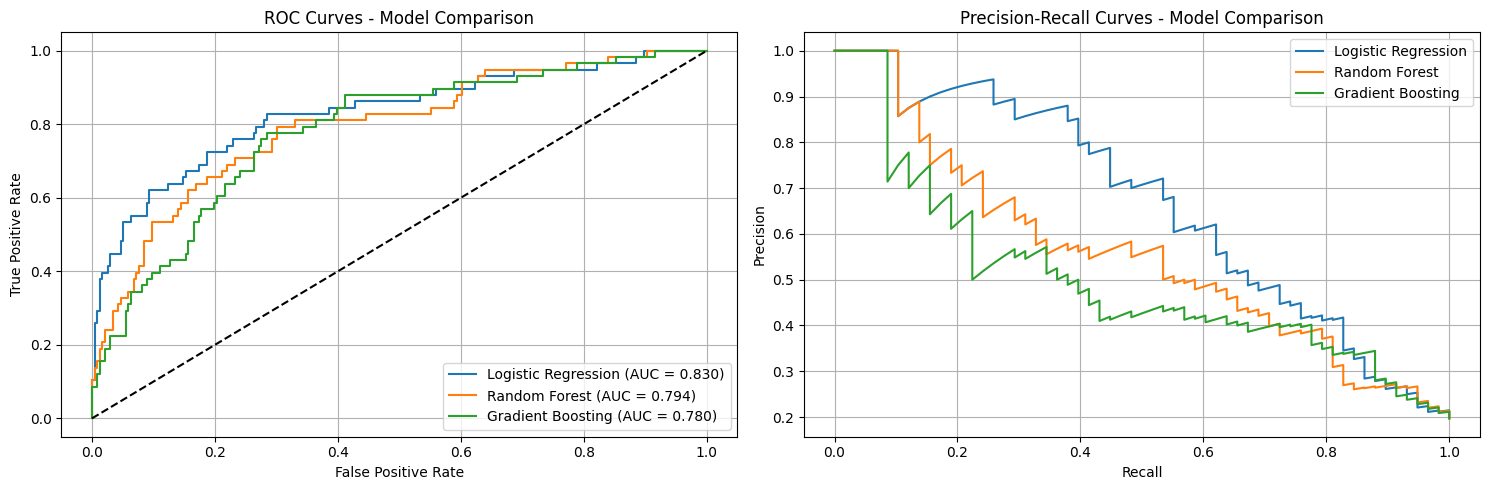

In [47]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Plot comparison curves for all models
plt.figure(figsize=(15, 5))

# ROC curves
plt.subplot(1, 2, 1)
for name, model in best_models.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)

# Precision-Recall curves
plt.subplot(1, 2, 2)
for name, model in best_models.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
import joblib
import json

# Save the best model and preprocessing objects
print(f"\nSaving best model: {best_model_name}")
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl')
joblib.dump(dv, 'dict_vectorizer.pkl')

# Save model performance summary
performance_summary = {
    'best_model': best_model_name,
    'test_performance': test_results,
    'feature_names': dv.feature_names_,
    'best_params': cv_results[best_model_name]['best_params']
}

with open('model_performance.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)

print("Model and artifacts saved successfully!")


Saving best model: Logistic Regression
Model and artifacts saved successfully!
